(c) Copyright 2023 Enzo Alexander Cording - https://github.com/EnzoCording - GNU GPL v3.0

This pipeline walks through the entire functionalities of FleetRL

1) Creating a custom use-case
2) Training an RL agent
3) Building benchmark charging strategies
4) Comparing the RL agent to the benchmarks

This code could also be run in a .py file. Then, the code after the imports should be wrapped in:

    if __name__ == "__main__":
        #code here

to allow for parallel processing

**Importing dependencies**

In [1]:
import datetime as dt
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import Literal
import pandas as pd
import time
import os

from fleetrl.fleet_env.fleet_environment import FleetEnv
from fleetrl.benchmarking.benchmark import Benchmark
from fleetrl.benchmarking.uncontrolled_charging import Uncontrolled
from fleetrl.agent_eval.evaluation import Evaluation
from fleetrl.agent_eval.basic_evaluation import BasicEvaluation

from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, ProgressBarCallback, BaseCallback
from stable_baselines3.common.logger import HParam

from pink import PinkActionNoise
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise, NormalActionNoise

**Creating a custom use-case**

**General settings**
Under general settings, you can adjust how many vehicles to optimize for, whether you would like to create new schedules how long the episodes should be, etc.

In [2]:
# define fundamental parameters
run_name = "LMD_2022_arbitrage_PPO_test"
n_train_steps = 48  # number of hours in a training episode
n_eval_steps = 48  # number of hours in one evaluation episode
n_eval_episodes = 1  # number of episodes for evaluation
n_evs = 2  # number of evs
n_envs = 2  # number of envs parallel - has to be equal to 1, if train_freq = (1, episode) or default setting
time_steps_per_hour = 4  # temporal resolution
use_case: str = "lmd"  # for file name
scenario: Literal["arb", "tariff"] = "tariff"  # arbitrage or tariff
gen_new_schedule = False  # generate a new schedule - refer to schedule generator and its config to change settings
gen_new_test_schedule = False  # generate a new schedule for agent testing
real_time = False

**File saving**

**Training settings**
These more low-level settings allow you to change training-related parameters. Refer to the documentation of FleetRL and stable-baselines3 for further details. Observations are by default normalized within SB3, due to their rolling average normalization. You can also conduct absolute normalization via FleetRL.

In [3]:
# training parameters
norm_obs_in_env = False  # normalize observations in FleetRL (max, min normalization)
vec_norm_obs = True  # normalize observations in SB3 (rolling normalization)
vec_norm_rew = True  # normalize rewards in SB3 (rolling normalization)
total_steps = int(1e3)  # total training time steps
saving_interval = 5e2  # interval for saving the model

**Parameters for environment object creation**
Further settings can be adjusted below, view the comments and docs for more detailed explanations.

In [4]:
# environment arguments - adjust settings if necessary
# additional settings can be changed in the config files
env_kwargs = {"schedule_name": str(n_evs) + "_" + str(use_case) + ".csv",
              "building_name": "load_" + str(use_case) + ".csv",
              "use_case": use_case,
              "include_building": True,  # False removes building load from Observation
              "include_pv": True,  # False removes PV from Observation
              "time_picker": "random",  # Pick a random starting day in the schedule dataframe
              "deg_emp": False,  # empirical degradation calculation
              "include_price": True,  # False removes electricity prices from Observation
              "ignore_price_reward": False,  # True sets price-related reward coefficient to 0
              "ignore_invalid_penalty": False,  # True ignores penalties on invalid actions (charging an empty spot)
              "ignore_overcharging_penalty": False,  # True ignores penalties on charging signals above target SOC
              "ignore_overloading_penalty": False,  # True ignores grid connection overloading penalty
              "episode_length": n_train_steps,  # in hours
              "normalize_in_env": norm_obs_in_env,  # Conduct normalization within FleetRL
              "verbose": 0,  # Print statements, can slow down FPS
              "aux": True,  # Include auxiliary data (recommended)
              "log_data": False,  # Log data (Makes most sense for evaluation runs)
              "calculate_degradation": True,  # Calculate SOH degradation (Can slow down FPS)
              "target_soc": 0.85,  # Signals that would charge above target SOC are clipped
              "gen_schedule": gen_new_schedule,  # generate a new schedule
              "gen_start_date": "2022-01-01 00:00",  # if new schedule, start date
              "gen_end_date": "2022-12-31 23:59:59",  # if new schedule, end date
              "gen_name": "my_sched.csv",  # name of new schedule
              "gen_n_evs": 1,  # number of EVs in new sched, per EV it takes ca. 10-20 min.
              "seed": 42,  # Seed for RNG
              "real_time": real_time
              }

# commercial tariff scenario, fixed fee on spot price (+10 ct/kWh, and a 50% mark-up)
# Feed-in tariff orientates after PV feed-in, with 25% deduction
if scenario == "tariff":
    env_kwargs["spot_markup"] = 10
    env_kwargs["spot_mul"] = 1.5
    env_kwargs["feed_in_ded"] = 0.25
    env_kwargs["price_name"] = "spot_2021_new.csv"
    env_kwargs["tariff_name"] = "fixed_feed_in.csv"

# arbitrage scenario, up and down prices are spot price, no markups or taxes
elif scenario == "arb":
    env_kwargs["spot_markup"] = 0
    env_kwargs["spot_mul"] = 1
    env_kwargs["feed_in_ded"] = 0
    env_kwargs["price_name"] = "spot_2021_new.csv"
    env_kwargs["tariff_name"] = "spot_2021_new_tariff.csv"

**Environment object creation**
Vec_Env are created to enable multi-processing

In [5]:
train_vec_env = make_vec_env(FleetEnv,
                             n_envs=n_envs,
                             vec_env_cls=SubprocVecEnv,
                             env_kwargs=env_kwargs,
                             seed=env_kwargs["seed"])

train_norm_vec_env = VecNormalize(venv=train_vec_env,
                                  norm_obs=vec_norm_obs,
                                  norm_reward=vec_norm_rew,
                                  training=True,
                                  clip_reward=10.0)

env_kwargs["time_picker"] = "eval"

if gen_new_schedule:
    env_kwargs["gen_schedule"] = False
    env_kwargs["schedule_name"] = env_kwargs["gen_name"]

eval_vec_env = make_vec_env(FleetEnv,
                             n_envs=n_envs,
                             vec_env_cls=SubprocVecEnv,
                             env_kwargs=env_kwargs,
                             seed=env_kwargs["seed"])

eval_norm_vec_env = VecNormalize(venv=eval_vec_env,
                                  norm_obs=vec_norm_obs,
                                  norm_reward=vec_norm_rew,
                                  training=True,
                                  clip_reward=10.0)

This creates a schedule for testing the trained agents on unseen data

In [6]:
if gen_new_test_schedule:
    # generate an evaluation schedule
    test_sched_name = env_kwargs["gen_name"]
    if not test_sched_name.endswith(".csv"):
        test_sched_name = test_sched_name + "_test" + ".csv"
    else:
        test_sched_name = test_sched_name.strip(".csv")
        test_sched_name = test_sched_name + "_test" + ".csv"

    env_kwargs["gen_schedule"] = True
    env_kwargs["gen_name"] = test_sched_name

    test_vec_env = make_vec_env(FleetEnv,
                                n_envs=1,
                                vec_env_cls=SubprocVecEnv,
                                env_kwargs=env_kwargs,
                                seed=env_kwargs["seed"])

    env_kwargs["gen_schedule"] = False
    env_kwargs["schedule_name"] = test_sched_name

test_vec_env = make_vec_env(FleetEnv,
                            n_envs=n_envs,
                            vec_env_cls=SubprocVecEnv,
                            env_kwargs=env_kwargs,
                            seed=env_kwargs["seed"])

test_norm_vec_env = VecNormalize(venv=test_vec_env,
                                 norm_obs=vec_norm_obs,
                                 norm_reward=vec_norm_rew,
                                 training=True,
                                 clip_reward=10.0)

Callbacks are regularly called during training and enable useful functionalities such as logging or progress reporting. View SB3 docs for further information. Note that wandb callbacks are possible with SB3.

In [7]:
eval_callback = EvalCallback(eval_env=eval_norm_vec_env,
                             warn=True,
                             verbose=1,
                             deterministic=True,
                             eval_freq=max(10000 // n_envs, 1),
                             n_eval_episodes=5,
                             render=False,
                             )

class HyperParamCallback(BaseCallback):
    """
    Saves hyperparameters and metrics at start of training, logging to tensorboard
    """

    def _on_training_start(self) -> None:
        hparam_dict = {
            "algorithm": self.model.__class__.__name__,
            "learning rate": self.model.learning_rate,
            "gamma": self.model.gamma,
        }

        metric_dict = {
            "rollout/ep_len_mean": 0,
            "train/value_loss": 0.0,
        }

        self.logger.record(
            "hparams",
            HParam(hparam_dict, metric_dict),
            exclude=("stdout", "log", "json", "csv")
        )

    def _on_step(self) -> bool:
        return True

progress_bar = ProgressBarCallback()

## wandb callback possible, check documentation of SB3 and wandb

In [8]:
hyperparameter_callback = HyperParamCallback()

In [9]:
# model-related settings
n_actions = train_norm_vec_env.action_space.shape[-1]
param_noise = None
noise_scale = 0.1
seq_len = n_train_steps * time_steps_per_hour
action_noise = PinkActionNoise(noise_scale, seq_len, n_actions)

In [10]:
model = PPO(policy="MlpPolicy",
            verbose=0, # setting verbose to 0 can introduce performance increases in jupyterlab environments
            env=train_norm_vec_env,
            tensorboard_log="./fleetrl/rl_agents/trained_agents/tb_log")

# might introduce performance increases
            # gamma=0.99,
            # learning_rate=0.0005,
            # batch_size=128,
            # n_epochs=8,
            # gae_lambda=0.9,
            # clip_range=0.2,
            # clip_range_vf=None,
            # normalize_advantage=True,
            # ent_coef=0.0008,
            # vf_coef=0.5,
            # max_grad_norm=0.5,
            # n_steps=2048)

In [11]:
%reload_ext tensorboard
%tensorboard --logdir ./FleetRL/RL_agents/trained_agents/tb_log --port 6006 --bind_all

Launching TensorBoard...

In [12]:
comment = run_name
time_now = int(time.time())
trained_agents_dir = f"./fleetrl/rl_agents/trained_agents/vec_PPO_{time_now}_{run_name}"
logs_dir = f"{trained_agents_dir}/logs/"

if not os.path.exists(trained_agents_dir):
    os.makedirs(trained_agents_dir)

if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)

In [13]:
# model training
# models are saved in a specified interval: once with unique step identifiers
# model and the normalization metrics are saved as well, overwriting the previous file every time
for i in range(0, int(total_steps / saving_interval)):
    model.learn(total_timesteps=saving_interval,
                reset_num_timesteps=False,
                tb_log_name=f"PPO_{time_now}_{comment}",
                callback=[eval_callback, hyperparameter_callback, progress_bar])

    model.save(f"{trained_agents_dir}/{saving_interval * i}")

    # Don't forget to save the VecNormalize statistics when saving the agent
    tmp_dir = f"{trained_agents_dir}/tmp/"
    model_path = tmp_dir + f"PPO-fleet_{comment}_{time_now}"
    model.save(model_path)
    stats_path = os.path.join(tmp_dir, f"vec_normalize-{comment}_{time_now}.pkl")
    train_norm_vec_env.save(stats_path)

Output()

Process ForkServerProcess-2:
Process ForkServerProcess-1:
Process ForkServerProcess-6:
Process ForkServerProcess-5:
Process ForkServerProcess-4:
Process ForkServerProcess-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/enzo/Desktop/FleetRL/venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/subproc_vec_env.py", line 33, in _worker
    cmd, data = remote.recv()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  File "/usr/lib/p

Degradation was negative: -0.0001223734729488557.Recheck calcs if it happens often.Previous entry: Range    0.038594
Mean     0.805523
Count         1.0
Start          53
End            54
Name: 16, dtype: objectCurrent entry:        Range      Mean  Count Start End
16  0.038594  0.805523    1.0    53  54
17  0.442095  0.606886    0.5    17  55


KeyboardInterrupt: 

In [14]:
# environment arguments for evaluation
env_kwargs["time_picker"] = "static"  # Pick a random starting day in the schedule dataframe
env_kwargs["log_data"] = True,  # Log data (Makes most sense for evaluation runs)

In [15]:
eval: Evaluation = BasicEvaluation(n_steps=n_eval_steps,
                                   n_evs=n_evs,
                                   n_episodes=n_eval_episodes,
                                   n_envs=1)

In [16]:
stats_path = stats_path
model_path = model_path

rl_log = eval.evaluate_agent(env_kwargs=env_kwargs, norm_stats_path=stats_path, model_path=model_path)

-1026.8927


In [17]:
uncontrolled_charging: Benchmark = Uncontrolled(n_steps=n_eval_steps,
                                                n_evs=n_evs,
                                                n_episodes=n_eval_episodes,
                                                n_envs=1)

uc_log = uncontrolled_charging.run_benchmark(env_kwargs=env_kwargs, use_case=use_case)

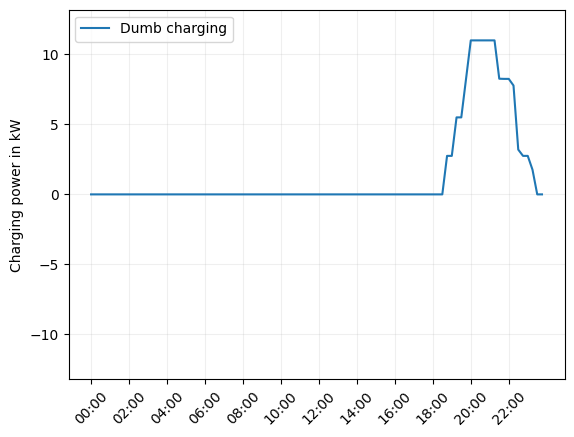

In [18]:
uncontrolled_charging.plot_benchmark(uc_log)

RL reward: -1026.9172071722282
DC reward: -112.75195114277152
RL cashflow: 0.6055749116468684
DC cashflow: -13.528041778132359
                     Category  RL-based charging  benchmark charging
0                      Reward       -1026.917207         -112.751951
1                    Cashflow           0.605575          -13.528042
2  Average degradation per EV           0.000570            0.000550
3                 Overloading           0.000000            0.000000
4               SOC violation           1.470005            0.000000
5                # Violations           3.000000            0.000000
6                         SOH           0.999430            0.999450


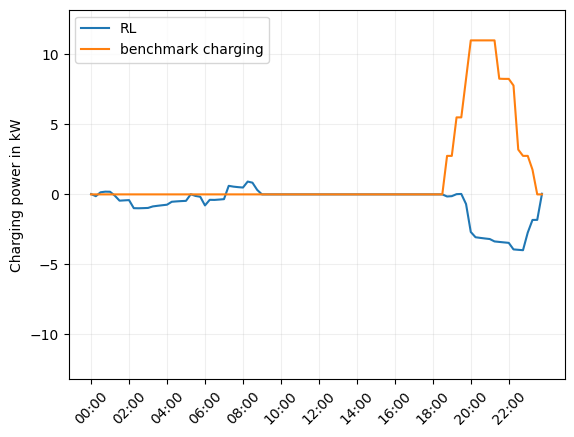

/home/enzo/Desktop/FleetRL/FleetRL/agent_eval/basic_evaluation.py:167: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels()[0:12])[0:12]


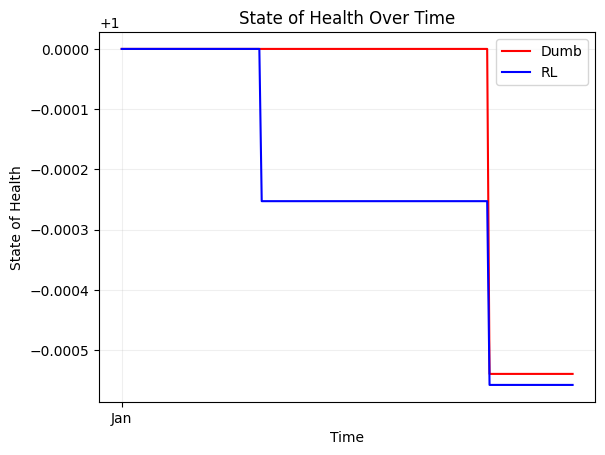

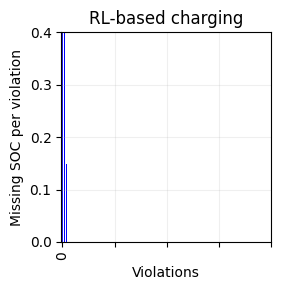

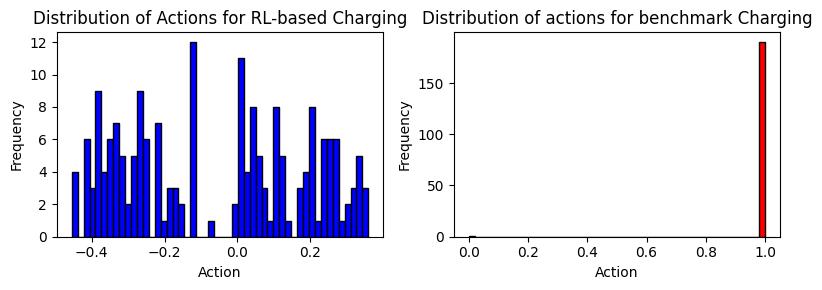

In [19]:
eval.compare(rl_log=rl_log, benchmark_log=uc_log)
eval.plot_soh(rl_log=rl_log, benchmark_log=uc_log)
eval.plot_violations(rl_log=rl_log, benchmark_log=uc_log)
eval.plot_action_dist(rl_log=rl_log, benchmark_log=uc_log)